In this notebook we will use the superCDMS dataset introduced in the previous notebook and perform some simple machine learning exercises to address the regression problem. In particular, we want to explore the regression problem of predicting the impact location based on the timing measurements provided in our dataset.

Let's load our dataset.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import *
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import seaborn as sns
import pandas as pd

In [2]:
## Get the dataset as numpy array

data = pd.read_csv('data/CDMS_Dataset.csv', sep=',')

features = list(data.columns)[1:]
x_data = data.values[:,1:-1]
y_data = data.values[:, -1]
n_features = len(features)

Now, we will perform some basic data engineering on our feature and target vectors. The different features in our dataset have very different numeric ranges. We want to rescale these features so their distributions have similar numerical ranges. We will also want to define a custom function to split our dataset into training and test sets.

In [3]:
# Split data into train and test sets

y_norm = -41.9 # largest y dimension to be used to normalize y data

def split_data(split_type='random', labels = []):
    if split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
    if split_type == 'label':
        X_train = data.loc[~data[features[-1]].isin(labels)].values[:, 1:-1]
        X_test = data.loc[data[features[-1]].isin(labels)].values[:, 1:-1]
        y_train =  data.loc[~data[features[-1]].isin(labels)].values[:, -1]
        y_test = data.loc[data[features[-1]].isin(labels)].values[:, -1]    
    
    
    x_mean = np.mean(X_train, axis = 0)
    x_std  = np.std(X_train, axis = 0)
    X_train = (X_train - x_mean)/x_std
    X_test  = (X_test - x_mean)/x_std
    y_train = y_train/y_norm
    y_test  = y_test/y_norm
    
    return X_train, X_test, y_train, y_test, x_mean, x_std

Now let's split the dataset into test and training sets. First, we will like to separate out all entries corresponding to $y = -12.502, -29.5, -41.9$, so we can explore our model's capacity of performing interpolation and extrapolation on unseen data.

Text(0, 0.5, 'Standardized Time measurements')

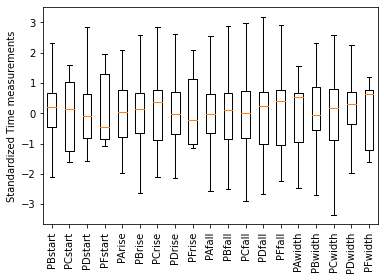

In [4]:
X_train, X_test, y_train, y_test, x_mean, x_std = split_data(split_type='label', 
                                                             labels = [-12.502, -29.5, -41.9])

bp = plt.boxplot(X_train, showfliers=False)
xticks = plt.xticks(range(1,20),features[:-1],rotation=90)
plt.ylabel("Standardized Time measurements")

Now, let's define a simple Linear Regression model for this problem. We want to model the relationship among $y$ and the feature vector $\vec{x} = \{x_1, x_2, ..., x_19 \}$ by the following linear equation:

\begin{equation}
y = \beta_0 + \sum_{i=1}^{19} \beta_i x_i
\end{equation}

The model is essentially described by the set of model parameters, the linear coefficients $\{\beta_i \}_{i=0}^19$. These coefficients are determined by minimizing the mean-squared-error (MSE) loss function

\begin{equation}
L = \frac{1}{N}\sum_{j=0}^{N-1} \left( y_j - \beta_0 - \sum_{i=1}^{19} \beta_i x_{ji} \right)^2
\end{equation}
where $y_j$ is the observed impact location of the $j$-th data point and $x_{ji}$ is the $i$-th feature of the $j$-th observation. We will use the `scikit-learn` package to perform this fit.

In [5]:
class CDMS_LR:
    def __init__(self, X_train, y_train, X_test, y_test, x_mean, x_std, mode="LR", alpha=1.0):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.x_mean = x_mean
        self.x_std = x_std
        if mode == "LR":
            self.LR = LinearRegression()
        if mode == "Ridge":
            self.LR = Ridge(alpha = alpha)
        if mode == "Lasso":
            self.LR = Lasso(alpha = alpha)
    
    
    def get_bias(self):
        return self.LR.intercept_
    
    def get_coefficients(self):
        return self.LR.coef_
    
    def do_LR(self, do_plot=True):
        self.LR = self.LR.fit(self.X_train, self.y_train)
        bias, coeffs = self.get_bias(), self.get_coefficients()
        coeffs = np.append(bias, coeffs)
        names = ['$\\beta_{' +str(i) +'}$' for i in range(20)]
        
        y_train_pred = self.LR.predict(self.X_train)
        MSE_train = np.sqrt(np.mean((y_train*y_norm - y_train_pred*y_norm)**2))
        
        y_test_pred = self.LR.predict(self.X_test)
        MSE_test = np.sqrt(np.mean((y_test*y_norm - y_test_pred*y_norm)**2))
        
        if do_plot:
            print("RMSE from train data = {}".format(MSE_train))
            print("RMSE from test data = {}".format(MSE_test))
        
            fig = plt.figure(figsize=(8,8))
            plt.scatter(names, coeffs)
            plt.plot(names, [0]*len(coeffs), color='k')
        
            fig = plt.figure(figsize=(8,8))
            plt.scatter(y_train*y_norm, y_train_pred*y_norm, marker='x', s=100, color='b', label='Train')
            plt.scatter(y_test*y_norm,  y_test_pred*y_norm, marker='.', color='r', label='Test')
            plt.plot(y_train*y_norm, y_train*y_norm, color='k')
            plt.xlabel("True Value")
            plt.ylabel("Predicted Value")
            plt.legend(fontsize = 20)
            plt.show()
        
        return MSE_train, MSE_test, coeffs

RMSE from train data = 1.4152108662142222
RMSE from test data = 1.9964235488702617


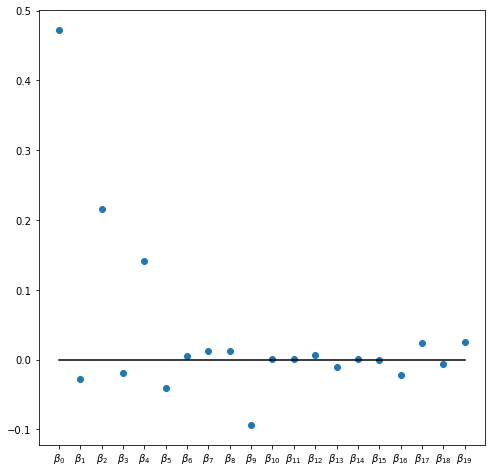

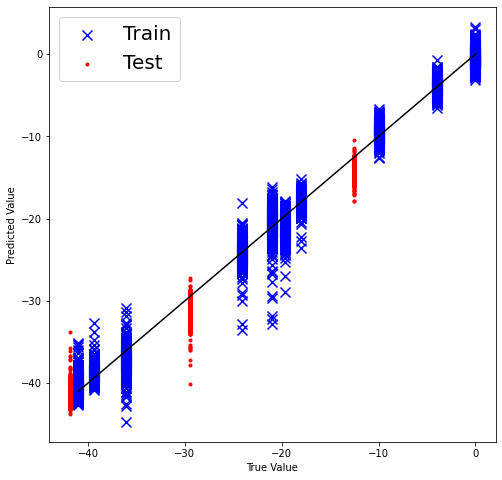

In [6]:
lr = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, mode="LR")
rmse_lr_train, rmse_lr_test, coeffs_lr = lr.do_LR()

As one can see, many of the coefficients are close zero. The performance of the model observes a relatively large variance in the distribution of predicted values. This might indicate that a non-linear model may perform better, but we will explore that later. One of the issues that we have subtly ignored so far is the issue of correlations among the features. Let's explore the correlation matrix of the feature and target vectors.

<AxesSubplot:>

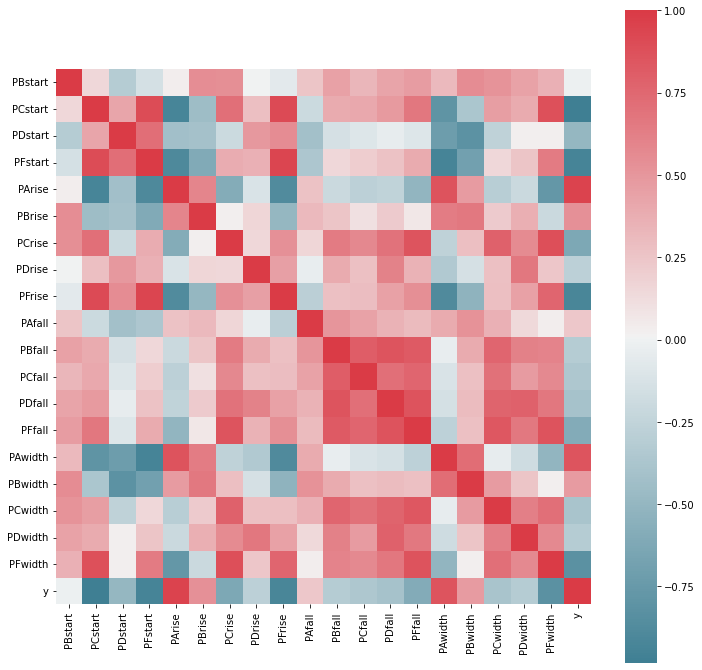

In [7]:
f, ax = plt.subplots(figsize=(12,12))
corr = data[features].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

We can see some strong correlations among the features. Numerically, this can cause the feature matrix to be near singular with low rank making its inversion unstable. In such problems, the recommended practice is to use a regularizer that will modify the loss function with an additional term that will act as a controller for the bias and coefficients. There are two main choices-

**Ridge Regularization:**

This includes a weighted $L_2$ norm of the weights in the loss function-

\begin{equation}
L = \frac{1}{N}\sum_{j=0}^{N-1} \left( y_j - \beta_0 - \sum_{i=1}^{19} \beta_i x_{ji} \right)^2 + \alpha\sum_{i=0}^{19} \beta_i^2
\end{equation}

**Lasso Regularization:**

This includes a weighted $L_1$ norm of the weights in the loss function-

\begin{equation}
L = \frac{1}{N}\sum_{j=0}^{N-1} \left( y_j - \beta_0 - \sum_{i=1}^{19} \beta_i x_{ji} \right)^2 + \alpha\sum_{i=0}^{19} |\beta_i|
\end{equation}

Let's explore these regularizations for the problem at hand. We will use $\alpha = 1.0$ for an initial choice of the regularization hyperparameter.

RMSE from train data = 1.4153153271979861
RMSE from test data = 1.9744986918693228


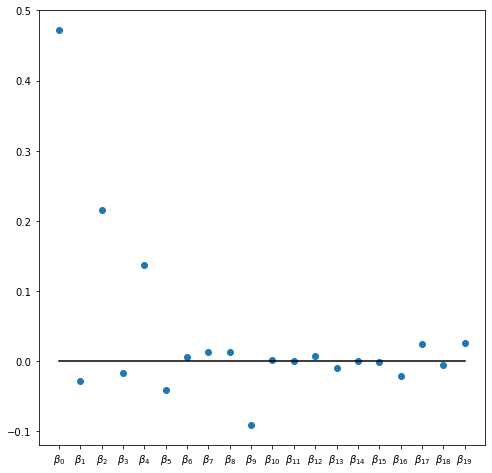

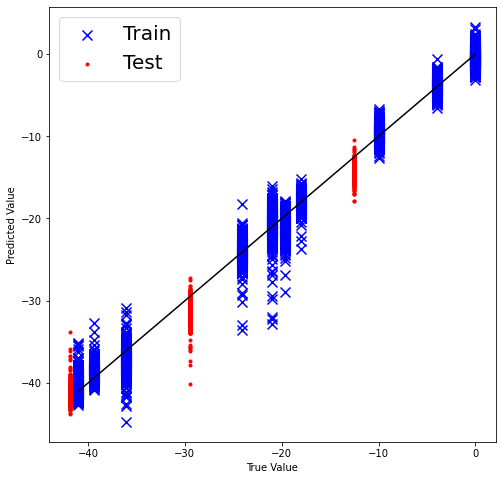

In [8]:
lr_ridge = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, mode="Ridge", alpha=1.0)
_, _, _ = lr_ridge.do_LR()

RMSE from train data = 14.154891196544527
RMSE from test data = 14.48994971534985


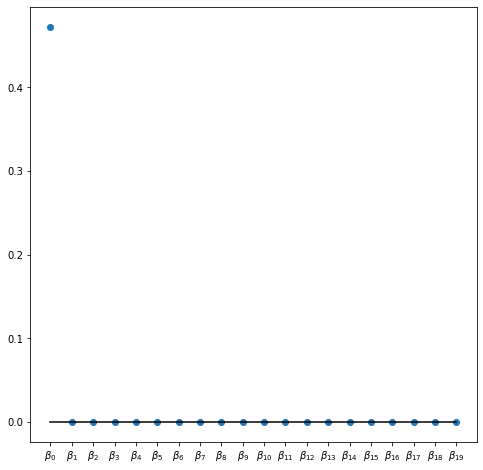

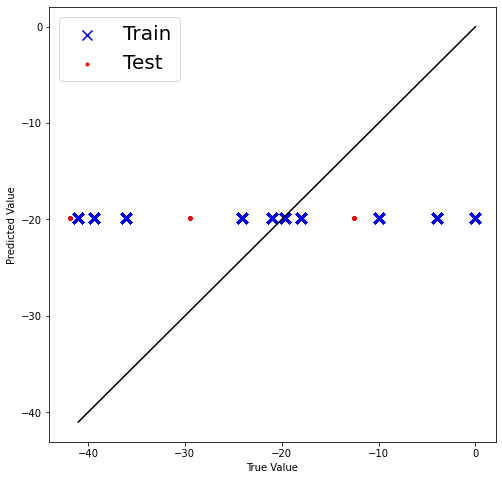

In [9]:
lr_lasso = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, mode="Lasso", alpha=1.0)
_, _, _ = lr_lasso.do_LR()

As we can see, the Ridge regressor with $\alpha = 1.0$ performs slightly better than the vanilla linear regressor. On the other hand, the Lasso regressor forces all coefficients to zero and the performance is significantly worse. To make the best choice for $\alpha$, we can scan over a number of choices and see which choice gives the best performance.

In [10]:
alphas = np.logspace(-6, +6, 50)
RMSE_train_Ridge = []
RMSE_test_Ridge = []
RMSE_train_Lasso = []
RMSE_test_Lasso = []

for ii, alpha in enumerate(alphas):
    lr = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, mode="Ridge", alpha=alpha)
    etr, etst, _ = lr.do_LR(do_plot=False)
    RMSE_train_Ridge.append(etr)
    RMSE_test_Ridge.append(etst)
    lr = CDMS_LR(X_train, y_train, X_test, y_test, x_mean, x_std, mode="Lasso", alpha=alpha)
    etr, etst, _ = lr.do_LR(do_plot=False)
    RMSE_train_Lasso.append(etr)
    RMSE_test_Lasso.append(etst)

/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7426137716328887, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3821404238626043, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17088124378827185, tolerance: 0.06432147713979608
  positive)
/home/avik/anaconda3/envs/mypy37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objectiv

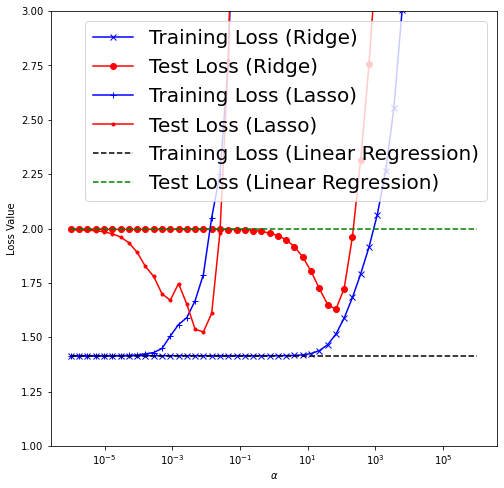

Minimum Test Loss for Ridge:  1.6291215002258335
Alpha for Minimum Test Loss for Ridge:  68.66488450042998
Minimum Test Loss for Lasso:  1.5244455151398457
Alpha for Minimum Test Loss for Lasso:  0.008286427728546842


In [11]:
fig = plt.figure(figsize=(8,8))
plt.plot(alphas, RMSE_train_Ridge, marker='x', color='b', label='Training Loss (Ridge)')
plt.plot(alphas, RMSE_test_Ridge, marker='o',  color='r', label='Test Loss (Ridge)')
plt.plot(alphas, RMSE_train_Lasso, marker='+', color='b', label='Training Loss (Lasso)')
plt.plot(alphas, RMSE_test_Lasso, marker='.', color='r', label='Test Loss (Lasso)')

plt.plot(alphas, [rmse_lr_train]*len(alphas), color='k', linestyle='--', label='Training Loss (Linear Regression)')
plt.plot(alphas, [rmse_lr_test]*len(alphas), color='g', linestyle = '--', label='Test Loss (Linear Regression)')

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel("Loss Value")
plt.legend(fontsize = 20)
plt.ylim([1.0, 3.0])
plt.show()

print("Minimum Test Loss for Ridge: ", min(RMSE_test_Ridge))
print("Alpha for Minimum Test Loss for Ridge: ", alphas[RMSE_test_Ridge.index(min(RMSE_test_Ridge))])

print("Minimum Test Loss for Lasso: ", min(RMSE_test_Lasso))
print("Alpha for Minimum Test Loss for Lasso: ", alphas[RMSE_test_Lasso.index(min(RMSE_test_Lasso))])